# Demo for Property Inference Attack (PIA)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/privML/privacy-evaluator/blob/team2sprint4/notebooks/property_inference_attack.ipynb) [![Open in Github](https://raw.githubusercontent.com/privML/privacy-evaluator/main/notebooks/images/GitHub-Mark-32px.png)](https://github.com/privML/privacy-evaluator/blob/team2sprint4/notebooks/property_inference_attack.ipynb)

## Overview
In this notebook, we want to show you how to use the privacy-evaluator tool to perform the Property Inference Attack on a provided pytorch model trained with the MNIST dataset. The goal of the property inference attack is (given a trained model) find out whether the training dataset of this model has some property (for more detailed information on the property inference attack see https://dl.acm.org/doi/pdf/10.1145/3243734.3243834 or on [Youtube](https://www.youtube.com/watch?v=99YHPIsKzCc&)). You can see a visualization of the attack in the next cell. In our example the property we're trying to find out is the class distribution of the training dataset.

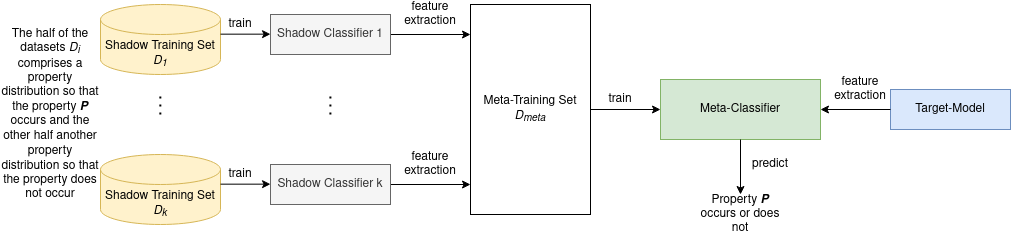

In [29]:
from IPython import display
display.Image("https://i.imgur.com/IX1M3TX.png")

## Setup

First, you should set the notebook's runtime to use a GPU (e.g. if Colab is used go to ***Runtime > Change runtime type > Hardware accelerator***). Now we can install the `privacy-evaluator` package and import all needed modules.

In [3]:
!pip3 install git+https://github.com/privML/privacy-evaluator@team2sprint4

  Cloning https://github.com/privML/privacy-evaluator (to revision team2sprint4) to /private/var/folders/_b/r90tkt1x6tvfxwwbrkgtkbpc0000gn/T/pip-req-build-42g_q3q8
  Running command git clone -q https://github.com/privML/privacy-evaluator /private/var/folders/_b/r90tkt1x6tvfxwwbrkgtkbpc0000gn/T/pip-req-build-42g_q3q8
  Running command git checkout -b team2sprint4 --track origin/team2sprint4
  Switched to a new branch 'team2sprint4'
  Branch 'team2sprint4' set up to track remote branch 'team2sprint4' from 'origin'.


In [7]:
import os
os.chdir("/Users/mariesigmund/Desktop/SS_21/Softwareprojekt/privacy-evaluator/")

from privacy_evaluator.attacks.property_inference_attack import PropertyInferenceAttack
from privacy_evaluator.classifiers.classifier import Classifier
from privacy_evaluator.utils.data_utils import (
    dataset_downloader,
    new_dataset_from_size_dict,
)
from privacy_evaluator.utils.trainer import trainer
from privacy_evaluator.models.torch.cnn import ConvNet

import collections
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Conduct Property Inference Attack
Now we can start with conducting the Property Inference Attack.


## 1. Overview of the dataset
First we want you to get to the dataset we are working with.
MNIST is a dataset of black-and-white handwritten digits from 10 classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), consisting of 60000 training- and 10000 test-images.
The size of each image is $28\times 28 \times 1$. You can see some sample images printed below.



In [9]:
train_dataset, test_dataset = dataset_downloader("MNIST")
input_shape = test_dataset[0][0].shape
print(f"Input shape: {input_shape}")

Input shape: (28, 28, 1)


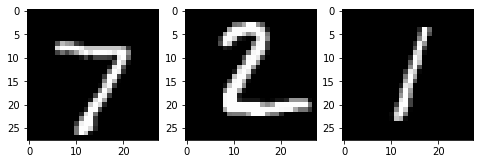

In [10]:
#Print images
images = test_dataset[0][:3]
_, axs = plt.subplots(1, 3, figsize=(8, 8))
axs = axs.flatten()
for image, ax in zip(images, axs):
    ax.imshow(image, cmap='gray')
plt.show()

As of now we can only perform binary attacks. A binary attack is a attack, where the target model is only classifying into 2 different classes which means that the datasets only contain two different classes. Therefore as an example we use classes 0 and 1 from MNIST, which represent the digits 0 and 1.

First we specify a distribution of these two classes and adjust the MNIST dataset accordingly. On this adjusted dataset we will train our target model and later the attacks goal is to predict this distribution.

In [14]:
NUM_ELEMENTS_PER_CLASSES = {0: 1000, 1: 500}
train_set = new_dataset_from_size_dict(train_dataset, NUM_ELEMENTS_PER_CLASSES)
print(train_set[0].shape, train_set[1].shape)

(1500, 28, 28, 1) (1500,)


## 2. Load and train target model
Now we load our model. We use a CNN and train it on the dataset created in the step before.


In [16]:
num_classes = len(NUM_ELEMENTS_PER_CLASSES)
model = ConvNet(num_classes, input_shape, num_channels=(input_shape[-1], 16, 32, 64))
trainer(train_set, NUM_ELEMENTS_PER_CLASSES, model, num_epochs=8)

# Convert to ART classifier

target_model = Classifier._to_art_classifier(model, "sparse_categorical_crossentropy", num_classes, input_shape)

## 3. Perform attack

One property inference attack consists of several sub-attack for different distributions of the training data. One subattacks is running for one ratio (e.g. 66% class 0, 34% class 1) and predicts whether it's more likely that the distribution of the training data of the target model was according to this special ratio or a balanced distribution(50% class 0, 50% class 1).
We specify the ratios in `ratios_for_attack`. We only specify one ratio for class 0 in the list, the other one for class 1 is computed in the attack.
The whole attack then checks, which distribution has the highest probability.

In every sub-attack we create a number of shadow classifiers of the same architecture as the provided target model. The shadow classifiers are neural networks which later serve as training set for a meta classifier. The meta classifier is the model which finally predicts the likelihood of the target model to have a given property (i.e. the ratio).
Half of the shadow classifiers will be trained on an unbalanced data set of the given ratio (e.g. 66% class 0, 34% class 1), the other half is trained on blanced data sets (50% class 0, 50% class 1).

We first define the `number_of_shadow_classifiers`. In `size_set` we define the size of the training data sets for each shadow classifier. For both parameters we chose a really small numbers due to runtime issues, but for a real attack <1000 shadow classifiers are not recommended and also the size set should be increased according to the size of the dataset you're sampling from. In the case of MNIST set sizes between 500 and 1500 are reasonable.

In [26]:
# Number of shadow classifiers (increase for better accuracy of the meta classifier, decrease when not enough computing power is available.)
number_of_shadow_classifiers = 2 #needs to be even

# Size of data set to train the shadow classifiers
size_set = 6
#Ratios to perform the attack for (the real ratios of our example target model is 0.66: {0: 1000, 1: 500}: 66% of data points are from class 0, 33% from class 1.)
ratios_for_attack = [0.66,0.05]
classes = [0,1]

Now we perform the attack and safe the output in the variable `output`. The output consists of two elements. One is a string with a message where the actual prediction is printed. The other one is a dictionary where for every ratio specified before in `ratios_for attack` we get the likelihood that the training set was this ratio.

In [27]:
attack = PropertyInferenceAttack(target_model, train_set, verbose=1, size_set=size_set, \
    ratios_for_attack=ratios_for_attack, classes=classes,amount_sets=number_of_shadow_classifiers)
output = attack.attack()

Initiating Property Inference Attack ... 
Extracting features from target model ... 
(97634,)  --- features extracted from the target model.
Creating set of 1 balanced shadow classifiers ... 
Creating shadow training sets
Training shadow classifiers
Performing PIA for various ratios ... 
  0%|          | 0/2 [00:00<?, ?it/s]Creating shadow training sets
Training shadow classifiers
Epoch 1/2
1/1 [==============================] - 24s 24s/step - loss: 0.3359 - accuracy: 1.0000
Epoch 2/2
 50%|█████     | 1/2 [00:44<00:44, 44.19s/it]Creating shadow training sets
Training shadow classifiers
Epoch 1/2
1/1 [==============================] - 24s 24s/step - loss: 0.2151 - accuracy: 1.0000
Epoch 2/2
100%|██████████| 2/2 [01:11<00:00, 35.62s/it]


The human readable output message is the string, it gives us the actual prediction:

In [30]:
output[0]

'The most probable property is class 0: 0.95, class 1: 0.05 with a probability of 0.50660240650177.'

And the more detailed output you could use for visualization or further analysis is the dictionary.
If all the probabilities are close to 0.5 and none is standing out significantly from all the others you could try using more shadow classifiers (= make the training set for the meta classifier larger).

In [31]:
output[1]

{'class 0: 0.95, class 1: 0.05': 0.5066024,
 'class 0: 0.34, class 1: 0.66': 0.492016}